## Objective

To make a recommendation system that recommends at least five(5) new products based on the user's habits.

## Read and explore the given dataset.

In [1]:
import numpy as np 
import pandas as pd 
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
df = pd.read_csv("ratings_Electronics.csv", header=None, index_col=None)
df.columns = ['userId', 'productId', 'rating', 'timestamp']
df.to_csv("ratings_Electronics.csv", index=False)

In [3]:
df.head()

,userId,productId,rating,timestamp
0,AKM1MP6P0OYPR,132793040,5,1365811200
1,A2CX7LUOHB2NDG,321732944,5,1341100800
2,A2NWSAGRHCP8N5,439886341,1,1367193600
3,A2WNBOD3WNDNKT,439886341,3,1374451200
4,A1GI0U4ZRJA8WN,439886341,1,1334707200


In [4]:
df.shape

(1048576, 4)

In [5]:
df.dtypes

userId       object
productId    object
rating        int64
timestamp     int64
dtype: object

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048576 entries, 0 to 1048575
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   userId     1048576 non-null  object
 1   productId  1048576 non-null  object
 2   rating     1048576 non-null  int64 
 3   timestamp  1048576 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 32.0+ MB


## Five Point Summary

In [12]:
df.describe()['rating'].T

count    1.048576e+06
mean     3.973380e+00
std      1.399329e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

## Dealing with missing values.

In [8]:
print('Number of missing values across columns: \n',df.isnull().sum())

Number of missing values across columns: 
 userId       0
productId    0
rating       0
timestamp    0
dtype: int64


## Visualizing the ratings.

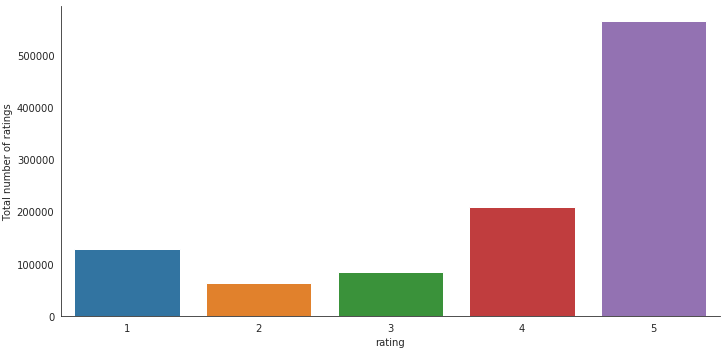

In [9]:
with sns.axes_style('white'):
    g = sns.factorplot("rating", data=df, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

## Insights:
From the plot it is seen that most of the people have given the rating of 5.

## Fetching the details of users and products.

In [10]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",df.shape[0])
print("Total No of Users   :", len(np.unique(df.userId)))
print("Total No of products  :", len(np.unique(df.productId)))

Total data 
--------------------------------------------------

Total no of ratings : 1048576
Total No of Users   : 786330
Total No of products  : 61894


## Dropping unwanted columns.

In [13]:
## Dropping the timestamp columns as it is not required for further analysis.
df.drop(['timestamp'], axis=1,inplace=True)

## Analyzing the ratings of the products.

In [14]:
no_of_rated_products_per_user = df.groupby(by='userId')['rating'].count().sort_values(ascending=False)

no_of_rated_products_per_user.head()

userId
A5JLAU2ARJ0BO     412
A231WM2Z2JL0U3    249
A25HBO5V8S8SEA    164
A6FIAB28IS79      146
AT6CZDCP4TRGA     128
Name: rating, dtype: int64

In [15]:
## Fetching the 5 point summary based on the products being rated.
no_of_rated_products_per_user.describe()

count    786330.000000
mean          1.333506
std           1.385612
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         412.000000
Name: rating, dtype: float64

In [16]:
quantiles = no_of_rated_products_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')

<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'Quantiles and their Values')

Text(0, 0.5, 'No of ratings by user')

Text(0.5, 0, 'Value at the quantile')

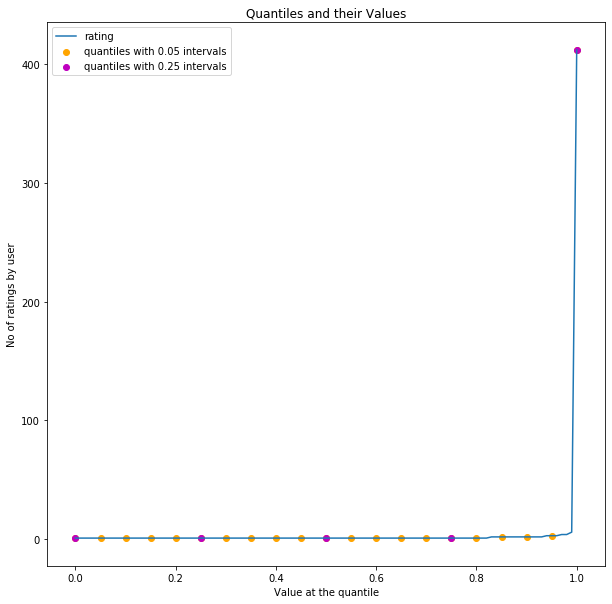

In [17]:
plt.figure(figsize=(10,10))
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()

In [18]:
print('\n No of rated product more than 50 per user : {}\n'.format(sum(no_of_rated_products_per_user >= 50)) )


 No of rated product more than 50 per user : 38



## Build a Popularity Recommender model.

In [19]:
new_df=df.groupby("productId").filter(lambda x:x['rating'].count() >=50)

Text(0.5, 1.0, '# RATINGS per Product')

Text(0.5, 0, 'Product')

Text(0, 0.5, 'No of ratings per product')

[]

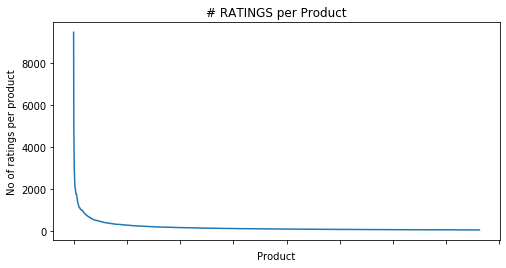

In [20]:
no_of_ratings_per_product = new_df.groupby(by='productId')['rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_product.values)
plt.title('# RATINGS per Product')
plt.xlabel('Product')
plt.ylabel('No of ratings per product')
ax.set_xticklabels([])

plt.show()

In [21]:
new_df.groupby('productId')['rating'].mean().head()

productId
1400501466    3.560000
1400501520    4.243902
1400501776    3.884892
1400532620    3.684211
1400532655    3.727273
Name: rating, dtype: float64

In [22]:
new_df.groupby('productId')['rating'].mean().sort_values(ascending=False).head()

productId
B0000DYV9H    4.947368
B000053HC5    4.945783
B00009R96C    4.885714
B00005LE76    4.879310
B000I1X3W8    4.869565
Name: rating, dtype: float64

In [23]:
#Total no of rating for product
new_df.groupby('productId')['rating'].count().sort_values(ascending=False).head()

productId
B0002L5R78    9487
B0001FTVEK    5345
B000I68BD4    4903
B000BQ7GW8    4275
B00007E7JU    3523
Name: rating, dtype: int64

In [24]:
ratings_mean_count = pd.DataFrame(new_df.groupby('productId')['rating'].mean())

In [25]:
ratings_mean_count['rating_counts'] = pd.DataFrame(new_df.groupby('productId')['rating'].count())

In [26]:
ratings_mean_count.head()

,rating,rating_counts
productId,,
1400501466,3.560000,250
1400501520,4.243902,82
1400501776,3.884892,139
1400532620,3.684211,171
1400532655,3.727273,484


In [27]:
ratings_mean_count['rating_counts'].max()

9487

<Figure size 576x432 with 0 Axes>

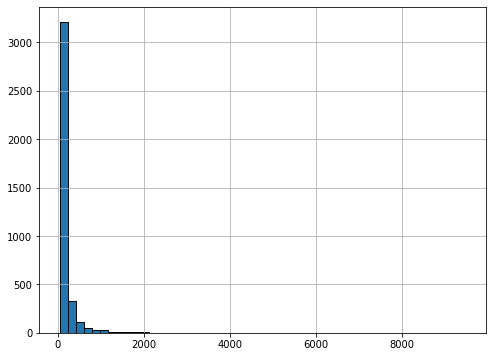

In [28]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating_counts'].hist(bins=50)

<Figure size 576x432 with 0 Axes>

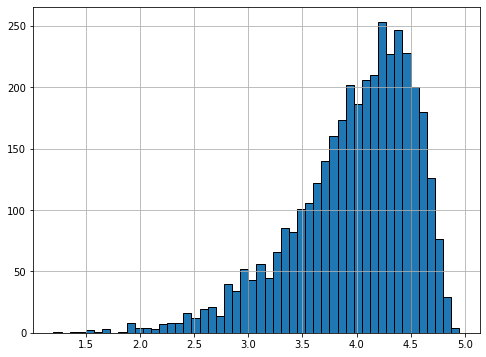

In [29]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating'].hist(bins=50)

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

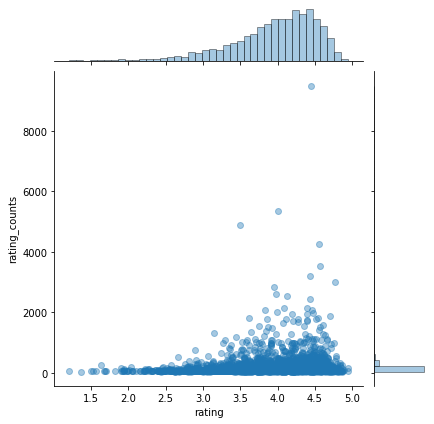

In [30]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='rating', y='rating_counts', data=ratings_mean_count, alpha=0.4)

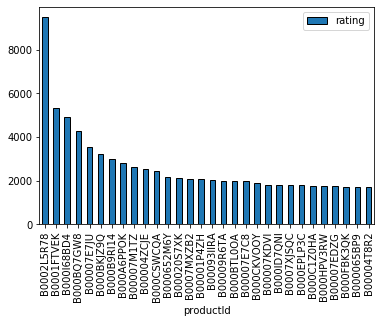

In [31]:
popular_products = pd.DataFrame(new_df.groupby('productId')['rating'].count())
most_popular = popular_products.sort_values('rating', ascending=False)
most_popular.head(30).plot(kind = "bar")

## Build a Collaborative Filtering model

In [32]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split

In [33]:
#Reading the dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(new_df,reader)

## Split the data randomly into train and test dataset.

In [34]:
trainset, testset = train_test_split(data, test_size=0.3,random_state=10)

In [35]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
algo = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [38]:
# Run the trained set against test
test_pred = algo.test(testset)

## Evaluating the model by computing the RMSE value.

In [39]:
# get RMSE
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

Item-based Model : Test Set
RMSE: 1.3436


1.343641161111319

## Get top - K ( K = 5) recommendations. Model-based collaborative filtering system to get top 5 recommendations based on user habits.

In [40]:
new_df1=new_df.head(10000)
ratings_matrix = new_df1.pivot_table(values='rating', index='userId', columns='productId', fill_value=0)
ratings_matrix.head()

productId,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400532736,1400599997,1400698987,3744295508,...,B00000JFMK,B00000JHWX,B00000JI4F,B00000JII6,B00000JMUG,B00000JPPI,B00000JSGF,B00000JYLO,B00000JYWQ,B00000K135
userId,,,,,,,,,,,,,,,,,,,,,
A01852072Z7B68UHLI5UG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0266076X6KPZ6CCHGVS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0293130VTX2ZXA70JQS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A030530627MK66BD8V4LN,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0571176384K8RBNKGF8O,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
ratings_matrix.shape

(9832, 76)

In [42]:
X = ratings_matrix.T
X.head()

userId,A01852072Z7B68UHLI5UG,A0266076X6KPZ6CCHGVS,A0293130VTX2ZXA70JQS,A030530627MK66BD8V4LN,A0571176384K8RBNKGF8O,A0590501PZ7HOWJKBGQ4,A0641581307AKT5MAOU0Q,A076219533YHEV2LJO988,A0821988FXKFYX53V4QG,A099626739FNCRNHIKBCG,...,AZWOPBY75SGAM,AZX0ZDVAFMN78,AZX5LAN9JEAFF,AZX7I110AF0W2,AZXKUK895VGSM,AZXP46IB63PU8,AZYTSU42BZ7TP,AZZGJ2KMWB7R,AZZMV5VT9W7Y8,AZZST8OYL5P4Q
productId,,,,,,,,,,,,,,,,,,,,,
1400501466,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400501520,0,0,0,0,0,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
1400501776,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1400532620,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400532655,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,0,0,0


In [43]:
X.shape

(76, 9832)

In [44]:
X1 = X

In [45]:
#Decomposing the Matrix
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(76, 10)

In [46]:
#Correlation Matrix

correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(76, 76)

In [47]:
X.index[75]

'B00000K135'

In [48]:
i = "B00000K135"

product_names = list(X.index)
product_ID = product_names.index(i)
product_ID

75

In [49]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(76,)

In [50]:
## The model recommends 5 similar products to user based on previous purchases.
Recommend = list(X.index[correlation_product_ID > 0.65])

# Removes the item already bought by the customer
Recommend.remove(i) 

Recommend[0:5]

['7214047977', '8862935293', '9573212919', '9888002198', '9984984354']

## Conclusion:
As per the objective given I have made a recommendation system that recommends 5 new products based on the user's habits.